code: 1

Available sheet names: ['Data\xa0_Dashboard']
First 5 rows of the Excel sheet for inspection (header=None):
                     0             1          2              3          4  \
0                 Date  Dengue_Cases  Mean_temp  Precipitation   Humidity   
1  2010-01-01 00:00:00             0       17.1       0.028571  78.742857   
2  2010-02-01 00:00:00             0       21.5       7.371429  78.628571   
3  2010-03-01 00:00:00             0       27.2           21.8  78.228571   
4  2010-04-01 00:00:00             0       29.5      75.485714  69.457143   

            5  
0  Wind_speed  
1        1.18  
2        1.12  
3        1.92  
4        2.69  

From the output above:
1. Identify the 0-indexed row number that contains the actual column headers (e.g., if it's the 3rd row, then header=2).
2. Note the exact spelling and casing of the 'Date' and 'Dengue_Cases' columns as they appear in that header row.
   (e.g., 'date', 'Date ', 'Dengue Cases', 'Dengue_cases', etc.)

Figure s

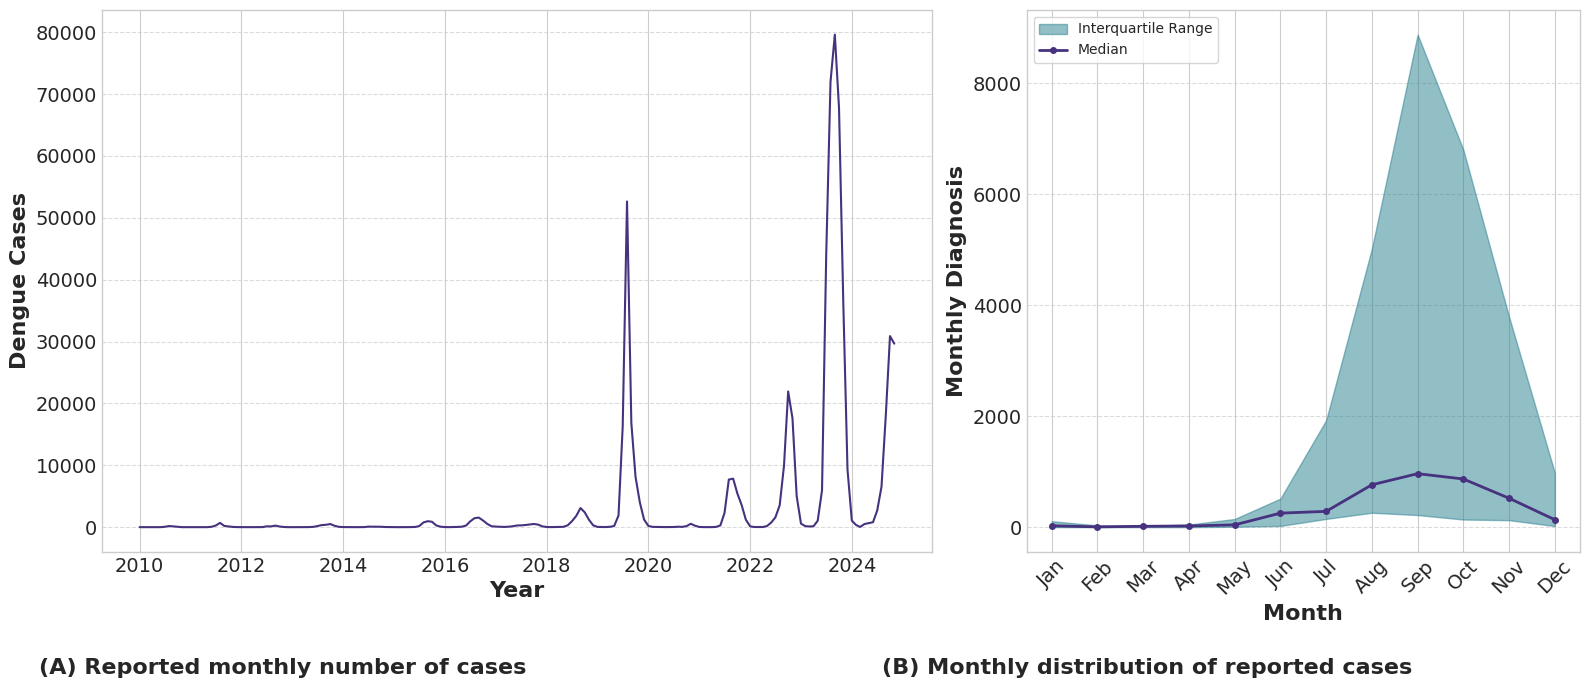

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.dates import DateFormatter

# Set a different style and color palette
sns.set_style("whitegrid")
palette = sns.color_palette("viridis", 6)

# 1. Load the data
file_path = '/content/journal.pone.xlsx'

# Inspect available sheet names
excel_file = pd.ExcelFile(file_path)
sheet_names = excel_file.sheet_names
print(f"Available sheet names: {sheet_names}")

# The data starts from the second row (index 1) which contains the column headers.
# The sheet name has a non-standard space, so we will use the exact name from the file read.

# --- Diagnostic Step to identify correct header and column names ---
# Read the Excel sheet without specifying a header to see the raw content from the very first row.
# This helps in identifying which row contains the actual column headers and their exact names.

# Assuming the correct sheet name is 'Data_Dashboard' (without the space), or similar.
# Please replace 'Data_Dashboard' with the correct sheet name identified from the above output.
correct_sheet_name = 'Data\xa0_Dashboard' # Corrected sheet name based on inspection

temp_df_for_inspection = pd.read_excel(file_path, sheet_name=correct_sheet_name, header=None)

print("First 5 rows of the Excel sheet for inspection (header=None):")
print(temp_df_for_inspection.head())
print("\nFrom the output above:")
print("1. Identify the 0-indexed row number that contains the actual column headers (e.g., if it's the 3rd row, then header=2).")
print("2. Note the exact spelling and casing of the 'Date' and 'Dengue_Cases' columns as they appear in that header row.")
print("   (e.g., 'date', 'Date ', 'Dengue Cases', 'Dengue_cases', etc.)\n")

# Once you have identified the correct header row number and column names,
# uncomment and modify the 'df = pd.read_excel(...)' line below with the correct parameters.
# For example, if headers are in row 1 (0-indexed) and column names are 'Date' and 'DengueCases':
# df = pd.read_excel(file_path, sheet_name=correct_sheet_name, header=1, usecols=['Date', 'DengueCases'])
# Example: If headers are in row 0 (0-indexed) and column names are 'Fecha' and 'Casos Dengue':
# df = pd.read_excel(file_path, sheet_name=correct_sheet_name, header=0, usecols=['Fecha', 'Casos Dengue'])
df = pd.read_excel(file_path, sheet_name=correct_sheet_name, header=0, usecols=['Date', 'Dengue_Cases'])

# Convert 'Date' to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for years 2010 to 2024
df_filtered = df[(df['Date'].dt.year >= 2010) & (df['Date'].dt.year <= 2024)].copy()


# 2. Prepare data for Plot A (Time Series)
# The data is already monthly, so we just need to ensure it's sorted
df_plot_a = df_filtered.sort_values('Date')

# 3. Prepare data for Plot B (Monthly Distribution)
df_plot_b = df_filtered.copy()
df_plot_b['Month'] = df_plot_b['Date'].dt.month
df_plot_b['Year'] = df_plot_b['Date'].dt.year

# Calculate the median and interquartile range (IQR) for each month
monthly_stats = df_plot_b.groupby('Month')['Dengue_Cases'].agg([
    'median',
    lambda x: x.quantile(0.25), # Q1
    lambda x: x.quantile(0.75)  # Q3
]).reset_index()
monthly_stats.columns = ['Month', 'Median', 'Q1', 'Q3']

# Map month numbers to month abbreviations for the x-axis
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_stats['Month_Name'] = monthly_stats['Month'].apply(lambda x: month_names[x-1])

# 4. Create the figure
fig = plt.figure(figsize=(16, 7)) # Increased figure size
gs = fig.add_gridspec(1, 2, width_ratios=[1.5, 1]) # Adjust ratios for better fit

# --- Plot A: Reported monthly number of cases (Time Series) ---
ax1 = fig.add_subplot(gs[0, 0])

# Use a line plot for the time series
ax1.plot(df_plot_a['Date'], df_plot_a['Dengue_Cases'], color=palette[0], linewidth=1.5)

# Formatting
#ax1.set_title('Reported monthly number of cases', loc='left', fontweight='bold')
ax1.set_ylabel('Dengue Cases', fontweight='bold', fontsize=16)
ax1.set_xlabel('Year', fontweight='bold', fontsize=16)
ax1.tick_params(axis='x', rotation=0, labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.xaxis.set_major_formatter(DateFormatter('%Y'))
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# --- Plot B: Monthly distribution of reported cases (Median and IQR) ---
ax2 = fig.add_subplot(gs[0, 1])

# Plot the Interquartile Range (IQR) as a shaded area
ax2.fill_between(
    monthly_stats['Month_Name'],
    monthly_stats['Q1'],
    monthly_stats['Q3'],
    color=palette[2], # A different color for the shaded area
    alpha=0.5,
    label='Interquartile Range'
)

# Plot the Median as a line
ax2.plot(
    monthly_stats['Month_Name'],
    monthly_stats['Median'],
    color=palette[0], # A distinct color for the median line
    marker='o',
    markersize=4,
    linewidth=2,
    label='Median'
)

# Formatting
#ax2.set_title('Monthly distribution of reported cases', loc='left', fontweight='bold')
ax2.set_ylabel('Monthly Diagnosis', fontweight='bold', fontsize=16)
ax2.set_xlabel('Month',fontweight='bold', fontsize=16)
ax2.set_xticks(monthly_stats['Month_Name'])
ax2.tick_params(axis='x', rotation=45, labelsize=14) # Rotate x-axis labels
ax2.tick_params(axis='y', labelsize=14)
ax2.legend(loc='upper left', frameon=True)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels (A) and (B) and titles below the figures
fig.text(0.18, -0.02, '(A) Reported monthly number of cases', ha='center', fontsize=16, fontweight='bold')
fig.text(0.72, -0.02, '(B) Monthly distribution of reported cases', ha='center', fontsize=16, fontweight='bold')


# Final layout adjustments
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for the text below
plt.savefig('dengue_figure_new_style.png', dpi=300)
print("Figure saved as dengue_figure_new_style.png")

/tmp/ipython-input-1206049032.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Month_Name', y='Dengue_Cases', data=df_plot_b_filtered, ax=ax2, palette=palette, flierprops=red_diamond)
/tmp/ipython-input-1206049032.py:17: UserWarning: 
The palette list has fewer values (6) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='Month_Name', y='Dengue_Cases', data=df_plot_b_filtered, ax=ax2, palette=palette, flierprops=red_diamond)


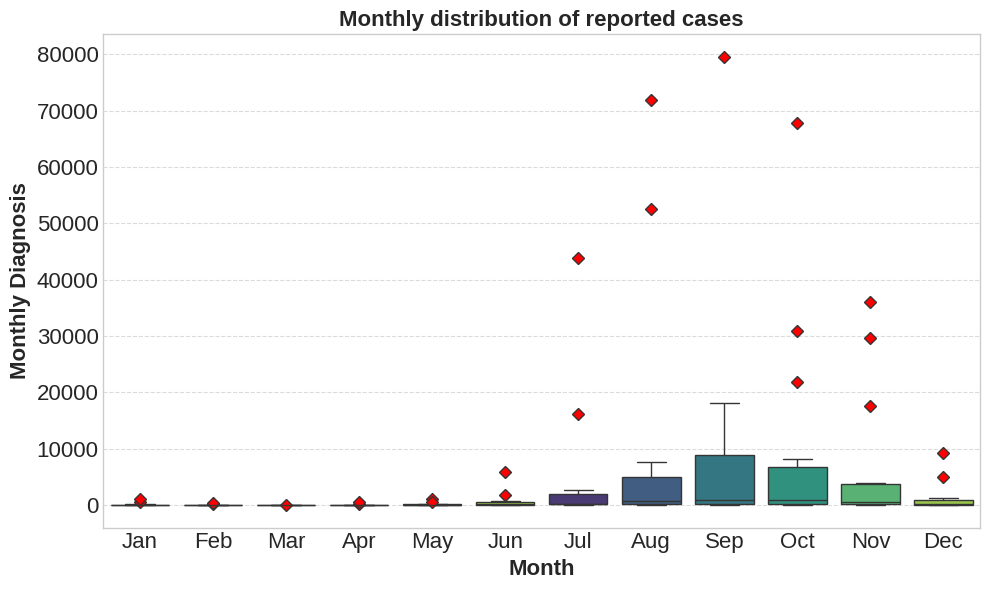

In [ ]:
# --- Plot B: Monthly distribution of reported cases (Box Plot) ---
fig_b, ax2 = plt.subplots(figsize=(10, 6)) # Adjusted size for a single plot

# Ensure 'Month_Name' column is available in df_plot_b (using df_filtered)
df_plot_b_filtered = df_filtered.copy()
if 'Month' not in df_plot_b_filtered.columns:
    df_plot_b_filtered['Month'] = df_plot_b_filtered['Date'].dt.month

if 'Month_Name' not in df_plot_b_filtered.columns:
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    df_plot_b_filtered['Month_Name'] = df_plot_b_filtered['Month'].apply(lambda x: month_names[x-1])

# Define flier properties for red outliers
red_diamond = dict(markerfacecolor='r', marker='D')

# Create a box plot using seaborn with red outliers, using df_filtered
sns.boxplot(x='Month_Name', y='Dengue_Cases', data=df_plot_b_filtered, ax=ax2, palette=palette, flierprops=red_diamond)

# Formatting
ax2.set_title('Monthly distribution of reported cases', loc='center', fontweight='bold', fontsize=16)
ax2.set_ylabel('Monthly Diagnosis', fontweight='bold', fontsize=16)
ax2.set_xlabel('Month',fontweight='bold', fontsize=16)

ax2.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='x', labelsize=16)

ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

codes for the climate time series and the comparison with dengue cases

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a professional style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# 1. Load the data
file_path = '/content/journal.pone.xlsx'

# The actual sheet name is 'Data\xa0_Dashboard' and headers are in row 0.
df = pd.read_excel(file_path, sheet_name='Data\xa0_Dashboard', header=0)

# Clean up column names by removing leading/trailing spaces
df.columns = df.columns.str.strip()

# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Select the relevant columns for analysis
data_cols = ['Dengue_Cases', 'Mean_temp', 'Precipitation', 'Humidity', 'Wind_speed']
df_analysis = df[data_cols].copy()

# --- ORIGINAL PLOTS ---

# 2. Time-Series Plot for Precipitation
plt.figure(figsize=(12, 6))
plt.plot(df_analysis.index, df_analysis['Precipitation'], marker='o', linestyle='-', color='#1f77b4', markersize=4, linewidth=1.5)
plt.title('Monthly Precipitation Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Year', fontsize=20, fontweight='bold')
plt.ylabel('Precipitation (mm)', fontsize=20, fontweight='bold')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.9)
plt.tight_layout()
plt.savefig('precipitation_time_series.png')
plt.close()
print("Generated: precipitation_time_series.png")

# 3. Time-Series Plot for Dengue Cases (to show relationship with Precipitation)
plt.figure(figsize=(12, 6))
plt.plot(df_analysis.index, df_analysis['Dengue_Cases'], marker='o', linestyle='-', color='#ff7f0e', markersize=4, linewidth=1.5)
plt.title('Monthly Dengue Cases Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=18, fontweight='bold')
plt.ylabel('Dengue Cases', fontsize=18, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('dengue_cases_time_series.png')
plt.close()
print("Generated: dengue_cases_time_series.png")

# 4. Scatter Plot: Precipitation vs. Dengue Cases (Correlation Analysis)
plt.figure(figsize=(8, 6))
sns.regplot(x='Precipitation', y='Dengue_Cases', data=df_analysis, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Relationship between Precipitation and Dengue Cases', fontsize=14, fontweight='bold')
plt.xlabel('Precipitation (mm)', fontsize=16, fontweight='bold')
plt.ylabel('Dengue Cases', fontsize=16, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('precipitation_vs_dengue_scatter.png')
plt.close()
print("Generated: precipitation_vs_dengue_scatter.png")

# 5. Correlation Heatmap for all variables
correlation_matrix = df_analysis.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, linecolor='black', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap of Meteorological Data and Dengue Cases', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(rotation=0, fontsize=16)
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.close()
print("Generated: correlation_heatmap.png")

# --- NEW PLOTS (Requested by User) ---

# 6. Time-Series Plot for Mean Temperature
plt.figure(figsize=(12, 6))
plt.plot(df_analysis.index, df_analysis['Mean_temp'], marker='o', linestyle='-', color='#1f77b4', markersize=4, linewidth=1.5)
plt.title('Monthly Mean Temperature Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Year', fontsize=20, fontweight='bold')
plt.ylabel('Mean Temperature (°C)', fontsize=20, fontweight='bold')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.9)
plt.tight_layout()
plt.savefig('mean_temp_time_series.png')
plt.close()
print("Generated: mean_temp_time_series.png")

# 7. Time-Series Plot for Humidity
plt.figure(figsize=(12, 6))
plt.plot(df_analysis.index, df_analysis['Humidity'], marker='o', linestyle='-', color='#1f77b4', markersize=4, linewidth=1.5)
plt.title('Monthly Humidity Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Year', fontsize=20, fontweight='bold')
plt.ylabel('Humidity (%)', fontsize=20, fontweight='bold')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.9)
plt.tight_layout()
plt.savefig('humidity_time_series.png')
plt.close()
print("Generated: humidity_time_series.png")

# 8. Time-Series Plot for Wind Speed
plt.figure(figsize=(12, 6))
plt.plot(df_analysis.index, df_analysis['Wind_speed'], marker='o', linestyle='-', color='#1f77b4', markersize=4, linewidth=1.5)
plt.title('Monthly Wind Speed Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Year', fontsize=20,fontweight='bold')
plt.ylabel('Wind Speed (m/s)', fontsize=20,fontweight='bold')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.9)
plt.tight_layout()
plt.savefig('wind_speed_time_series.png')
plt.close()
print("Generated: wind_speed_time_series.png")

# 9. Scatter Plot: Humidity vs. Dengue Cases (Correlation Analysis)
plt.figure(figsize=(8, 6))
sns.regplot(x='Humidity', y='Dengue_Cases', data=df_analysis, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Relationship between Humidity and Dengue Cases', fontsize=14, fontweight='bold')
plt.xlabel('Humidity (%)', fontsize=16, fontweight='bold')
plt.ylabel('Dengue Cases', fontsize=16, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('humidity_vs_dengue_scatter.png')
plt.close()
print("Generated: humidity_vs_dengue_scatter.png")

# 10. Scatter Plot: Wind Speed vs. Dengue Cases (Correlation Analysis)
plt.figure(figsize=(8, 6))
sns.regplot(x='Wind_speed', y='Dengue_Cases', data=df_analysis, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Relationship between Wind Speed and Dengue Cases', fontsize=14, fontweight='bold')
plt.xlabel('Wind Speed (m/s)', fontsize=16, fontweight='bold')
plt.ylabel('Dengue Cases', fontsize=16, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('wind_speed_vs_dengue_scatter.png')
plt.close()
print("Generated: wind_speed_vs_dengue_scatter.png")

# 11. Scatter Plot: Mean Temperature vs. Dengue Cases (Correlation Analysis)
plt.figure(figsize=(8, 6))
sns.regplot(x='Mean_temp', y='Dengue_Cases', data=df_analysis, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Relationship between Mean Temperature and Dengue Cases', fontsize=14, fontweight='bold')
plt.xlabel('Mean Temperature (°C)', fontsize=16, fontweight='bold')
plt.ylabel('Dengue Cases', fontsize=16, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('mean_temp_vs_dengue_scatter.png')
plt.close()
print("Generated: mean_temp_vs_dengue_scatter.png")


print("All plots generated successfully.")

Generated: precipitation_time_series.png
Generated: dengue_cases_time_series.png
Generated: precipitation_vs_dengue_scatter.png
Generated: correlation_heatmap.png
Generated: mean_temp_time_series.png
Generated: humidity_time_series.png
Generated: wind_speed_time_series.png
Generated: humidity_vs_dengue_scatter.png
Generated: wind_speed_vs_dengue_scatter.png
Generated: mean_temp_vs_dengue_scatter.png
All plots generated successfully.


Statistical Description

🔬 Dengue and Meteorological Data Analysis
📊 Dataset Overview:
Time period: 2010-01 to 2024-11
Total months: 179
Total dengue cases: 626,169

📈 1. DESCRIPTIVE STATISTICS ANALYSIS
Descriptive Statistics Table:
               Minimum    Maximum      Mean        Std  Skewness  Kurtosis  \
Variable                                                                     
Dengue Cases     0.000  79598.000  3498.151  11614.943     4.661    22.920   
Temperature     16.001     29.899    25.634      4.036    -0.855    -0.707   
Precipitation    0.029    816.571   193.203    191.035     0.739    -0.464   
Humidity        67.029     89.238    79.722      5.155    -0.630    -0.324   
Wind Speed       0.650      3.123     1.660      0.606     0.466    -0.501   

                Median      Q1       Q3      IQR  
Variable                                          
Dengue Cases   114.000  16.000  781.500  765.500  
Temperature     27.545  22.950   28.811    5.861  
Precipitation  125.343  18.157  348.736  

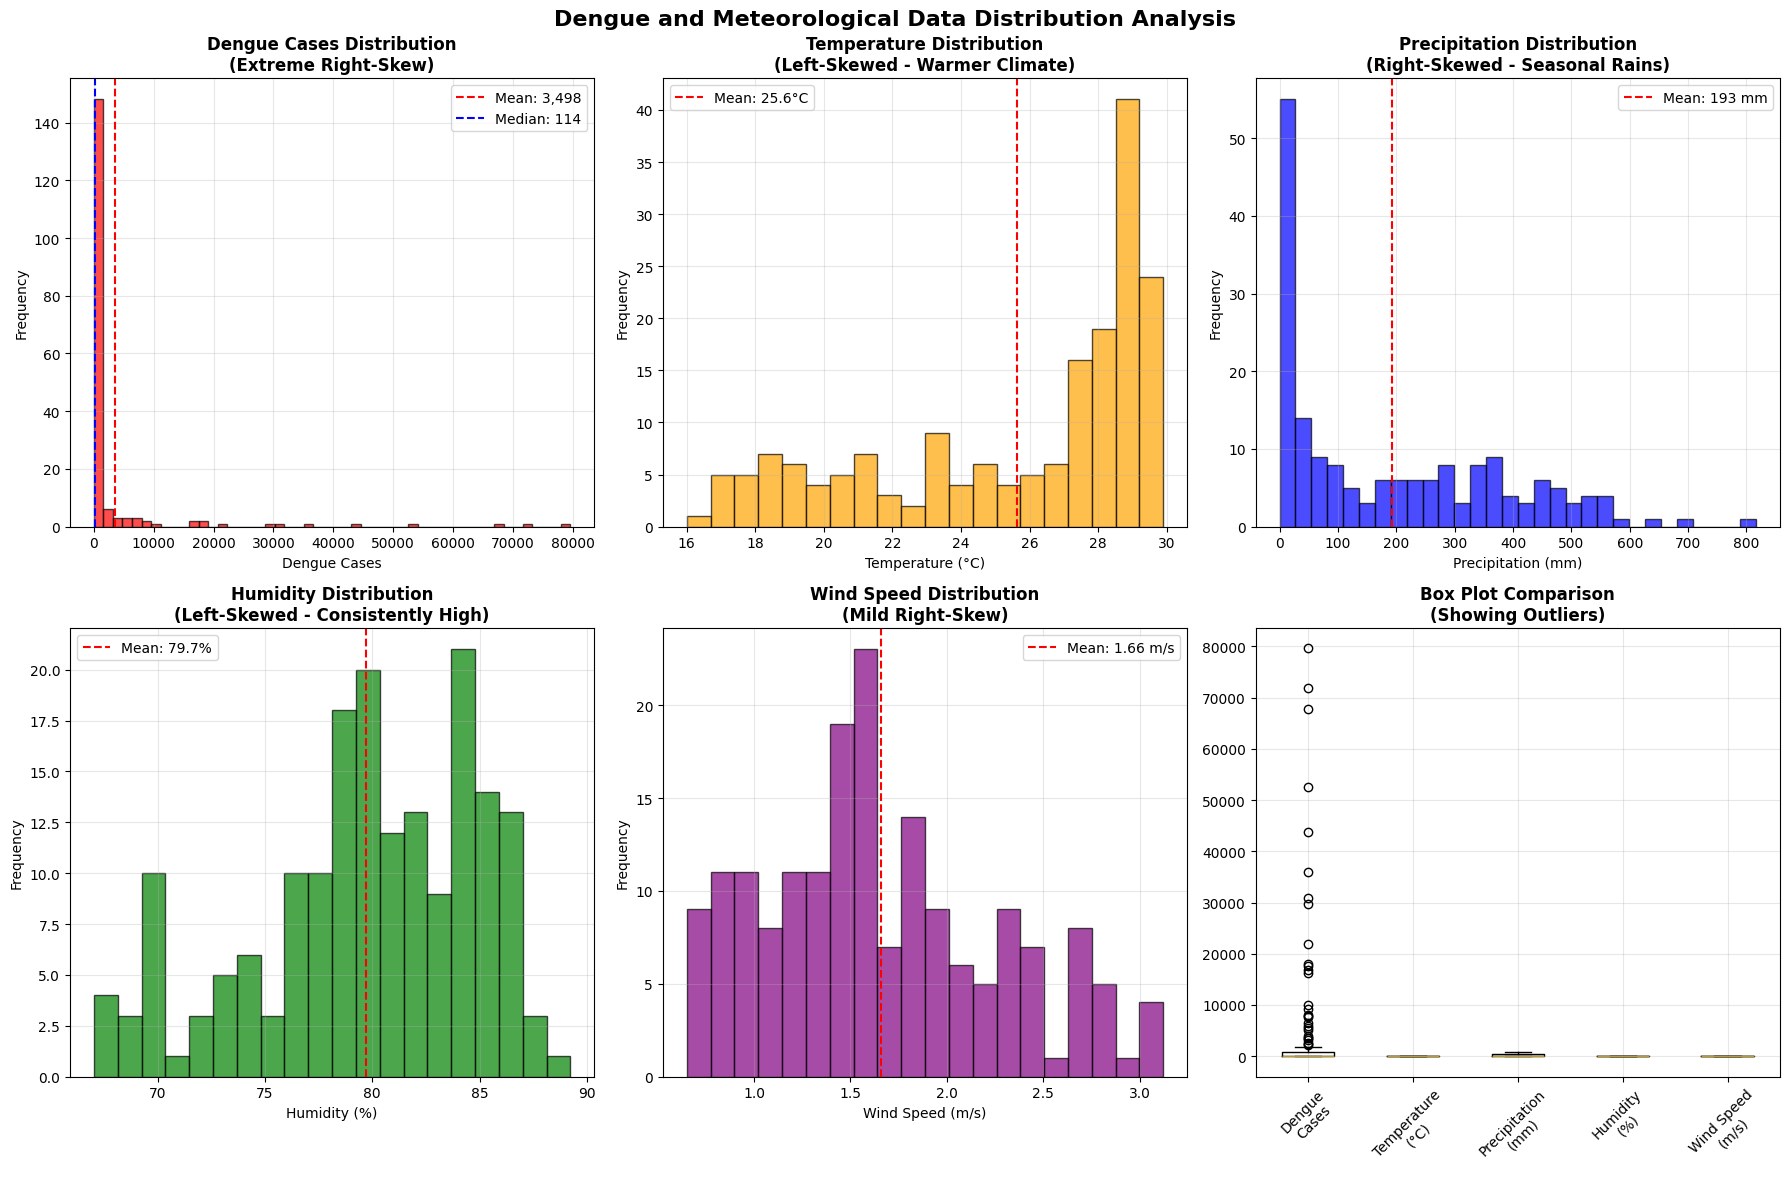


🚨 4. OUTBREAK ANALYSIS
Outbreak threshold (95th percentile): 18,480 cases
Number of major outbreak months: 9
Percentage of months with major outbreaks: 5.0%

Top 5 Largest Outbreaks:
          Date  Dengue_Cases  Mean_temp  Precipitation  Humidity
164 2023-09-30         79598      29.34         509.33     89.24
163 2023-08-31         71976      28.98         533.67     85.48
165 2023-10-31         67769      27.33         371.45     87.53
115 2019-08-31         52636      29.55         592.08     86.40
162 2023-07-31         43854      29.75         488.04     82.27

📅 5. SEASONAL PATTERN ANALYSIS
Monthly Averages:
       Dengue_Cases  Mean_temp  Precipitation  Humidity
Month                                                  
1            144.53      17.62           5.69     80.08
2             45.27      21.16          14.80     78.74
3             20.20      25.51          35.73     78.70
4             60.33      28.21         109.35     78.67
5            158.33      28.79         2

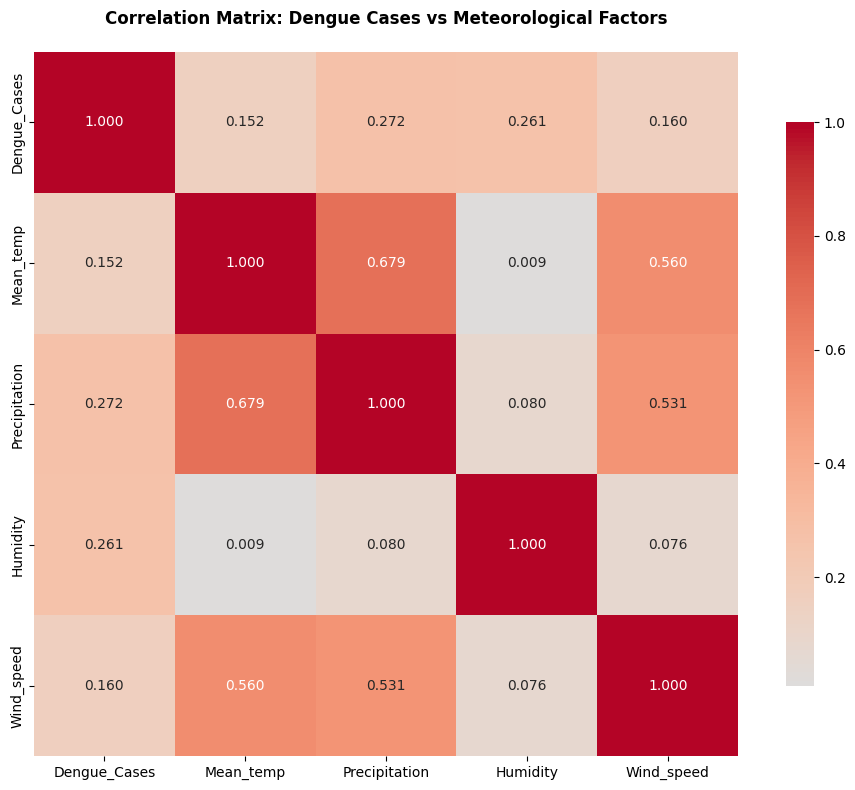

Correlation with Dengue Cases:
• Precipitation: 0.272 (Weak positive correlation)
• Humidity: 0.261 (Weak positive correlation)
• Wind_speed: 0.160 (Weak positive correlation)
• Mean_temp: 0.152 (Weak positive correlation)

🎯 7. KEY FINDINGS AND CONCLUSIONS

MAJOR FINDINGS:

1. 🦟 DENGUE EPIDEMIOLOGY:
   • Extreme volatility with catastrophic outbreak potential
   • Highly right-skewed distribution (Skewness: 4.66)
   • Heavy-tailed distribution (Kurtosis: 22.92)
   • Mean (3,498) >> Median (114) indicates outlier-driven epidemiology

2. 🌡️ CLIMATIC CONDITIONS:
   • Temperature: Consistently warm with left-skew (optimal for mosquitoes)
   • Precipitation: Right-skewed with seasonal heavy rains
   • Humidity: Pervasively high, favorable for mosquito survival
   • Wind Speed: Generally calm, not a limiting factor

3. 📈 TRANSMISSION DYNAMICS:
   • Climate provides perennial favorable conditions
   • Rainfall acts as outbreak trigger through habitat creation
   • Temperature maintains year-

In [ ]:
# Install required packages
!pip install scipy seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

print("🔬 Dengue and Meteorological Data Analysis")
print("=" * 50)

# Create DataFrame from the provided data
data = {
    'Date': pd.date_range('2010-01-01', periods=len([
        0,0,0,0,0,0,61,183,120,45,0,0,0,0,0,0,0,61,255,691,193,114,36,9,0,0,0,0,0,10,129,122,246,107,27,0,6,7,3,3,12,50,172,339,385,501,218,53,15,7,2,0,8,9,82,80,76,63,22,11,0,0,2,6,10,28,171,765,965,869,271,75,13,3,17,38,70,254,926,1451,1544,1077,522,145,92,58,36,73,134,267,286,346,430,512,409,126,26,7,19,29,52,295,946,1796,3087,2406,1192,293,38,18,17,58,193,1884,16253,52636,16856,8143,4011,1247,199,45,27,25,10,20,23,68,47,164,546,231,32,9,13,3,43,272,2286,7698,7841,5458,3567,1207,126,20,20,23,163,737,1571,3521,9911,21932,17583,5024,566,166,111,143,1036,5956,43854,71976,79598,67769,36021,9288,1055,339,36,504,644,798,2669,6521,18097,30879,29652
    ]), freq='M'),
    'Dengue_Cases': [
        0,0,0,0,0,0,61,183,120,45,0,0,0,0,0,0,0,61,255,691,193,114,36,9,0,0,0,0,0,10,129,122,246,107,27,0,6,7,3,3,12,50,172,339,385,501,218,53,15,7,2,0,8,9,82,80,76,63,22,11,0,0,2,6,10,28,171,765,965,869,271,75,13,3,17,38,70,254,926,1451,1544,1077,522,145,92,58,36,73,134,267,286,346,430,512,409,126,26,7,19,29,52,295,946,1796,3087,2406,1192,293,38,18,17,58,193,1884,16253,52636,16856,8143,4011,1247,199,45,27,25,10,20,23,68,47,164,546,231,32,9,13,3,43,272,2286,7698,7841,5458,3567,1207,126,20,20,23,163,737,1571,3521,9911,21932,17583,5024,566,166,111,143,1036,5956,43854,71976,79598,67769,36021,9288,1055,339,36,504,644,798,2669,6521,18097,30879,29652
    ],
    'Mean_temp': [
        17.1,21.5,27.2,29.5,29.1,28.8,29,29.1,28.5,27.8,24.5,19.3,16.9,21.4,25.3,27.4,28.4,28.7,28.7,28.2,28.3,27.8,23.2,19,18.2,21.1,26,27.8,29.7,29.3,28.4,28.8,28.6,27,22.9,17.9,16.9,21.6,26,28.2,27.7,29.4,28.8,28.4,28.6,26.9,23,19.4,17.7,20.4,25.3,29.5,29.7,29.1,29.1,28.5,28.6,27.2,23.4,19,18.6,21.5,25.3,27.3,29.4,28.9,28.2,28.7,28.9,27.3,23.9,19.7,18.1,23.1,26.6,29.6,28.6,29.3,28.4,29,28.8,27.9,23.5,20.5,18.8,22,24.5,27.6,29.5,28.9,28.4,28.9,28.8,27.4,23.9,20.6,16.000576923076924,21.500977564102563,25.593942307692306,26.64841346153846,27.340608974358975,29.06838141025641,28.93089743589744,29.26610576923077,29.013862179487184,26.23780448717949,22.785144230769234,18.61206730769231,18.111682692307692,20.619182692307696,24.541426282051283,27.42358974358974,29.21190705128205,29.515721153846155,28.891330128205123,29.552195512820514,28.465144230769226,26.83197115384615,23.866217948717946,18.330817307692307,17.385801282051283,19.70772435897436,24.62758012820513,26.771538461538462,27.97293269230769,28.822676282051283,28.886891025641027,29.244294871794875,28.838798076923077,28.422516025641023,23.380817307692308,18.745801282051282,17.892836538461538,20.914599358974353,26.22706730769231,28.61232371794872,28.65091346153846,28.391858974358975,28.93889423076923,28.731378205128205,29.047740384615384,28.05576923076923,23.037003205128205,19.74903846153846,17.944375,19.414107142857144,26.056607142857146,28.528214285714284,28.326875000000005,28.597857142857144,29.7075,29.466874999999998,28.760446428571427,27.244999999999997,23.493392857142858,19.79580357142857,17.83176282051282,21.68293269230769,24.979951923076925,28.295576923076922,28.69003205128205,29.370112179487183,29.74947115384615,28.976458333333337,29.336458333333333,27.33395833333333,24.17520833333333,20.360833333333332,16.820000000000004,21.029354838709676,24.443225806451615,29.899333333333338,29.53129032258064,29.704000000000008,29.58548387096774,28.649354838709684,29.04821504884005,27.544909188034186,23.5685347985348
    ],
    'Precipitation': [
        0.028571429,7.371428571,21.8,75.48571429,294.6,559.0857143,338.6571429,308.1142857,231.6857143,277.5428571,14.45714286,31.62857143,1.4,3.228571429,35.4,92.65714286,288,481.9142857,457.7428571,637.8285714,378.7428571,86.51428571,1.057142857,0.2,12.85714286,3.142857143,27.88571429,186.6857143,158.2857143,499.7428571,531.8,358,280.0285714,187.4,46.31428571,2.2,0.485714286,8.257142857,18.71428571,62.8,525.0857143,418.6,382.9142857,394.0857143,282.6857143,240.8,0.285714286,0.4,0.114285714,25.25714286,19.08571429,38.97142857,212.4285714,551.3428571,357.6285714,437.8,333.5428571,75.31428571,1.428571429,0.057142857,11.22857143,17.6,22.48571429,174.0857143,196.5142857,569.9142857,816.5714286,446.2,363.3428571,125.3428571,9.314285714,7.485714286,6.857142857,33,52.08571429,85.51428571,349.4285714,337.9142857,556.6857143,377.4285714,268.3142857,171.0571429,83.34285714,0.885714286,8.542857143,6.942857143,119.5714286,271.2285714,226.8285714,489.1428571,694.0285714,485.0857143,357.5428571,292.1714286,11.34285714,48.14285714,3.6825,12.27875,25.445,162.55875000000003,351.1125,406.875,448.38375,250.50625000000002,202.375,116.85625,7.33875,14.61875,0.33125,58.10375,36.4275,132.34625,259.99625,323.4625,535.10625,592.0825,306.775,191.84875,106.95,95.11,26.235,2.4725,23.904999999999998,141.4275,351.0625,422.4375,516.99875,359.72625,404.59124999999995,239.0025,26.29875,0.5925,0.59125,3.9837499999999997,21.307499999999997,59.8875,213.94125,466.85375,451.23375,439.96125,217.59,189.1525,47.54,51.40625,11.29125,33.971250000000005,13.82625,77.27875,331.77250000000004,429.2425,224.94125,289.73499999999996,348.0425,255.68,1.085,2.62,0.1825,3.66125,86.3575,71.52375,176.38,380.97249999999997,488.035,533.66875,509.33125,371.45,264.78125,28.2,1.56,2.74,11.66,7.83,33.43,66.92,58.35,92.44,291.65458333333333,238.76083333333335,124.46875
    ],
    'Humidity': [
        78.74285714285715,78.62857142857143,78.22857142857143,69.45714285714286,70.22857142857143,76,79.2,85.91428571428571,84.45714285714286,84.42857142857143,85.48571428571428,83.4,79.54285714285714,77.68571428571428,79.02857142857142,76.62857142857143,70.08571428571429,69.82857142857142,75.11428571428571,80.45714285714286,85,84.74285714285715,86.97142857142858,85.65714285714286,81.37142857142857,78.28571428571429,81.52941176470588,79.17647058823529,76.88571428571429,67.28571428571429,70.25714285714285,76.25714285714285,77.05714285714286,83.68571428571428,86.6,85.14285714285714,85.48571428571428,82.28571428571429,78.74285714285715,82.67647058823529,78.8529411764706,75.8,69.05714285714286,69.54285714285714,72.6969696969697,83.31428571428572,82.91428571428571,84.37142857142857,86.05714285714286,85.08571428571429,85.22857142857143,77.25714285714285,79.37142857142857,78.84848484848484,79.45714285714286,73.45714285714286,67.6,68.85714285714286,75.94285714285714,84.34285714285714,84.31428571428572,86.45714285714286,84.45714285714286,81.31428571428572,77.97142857142858,81.65714285714286,78.4,79.08823529411765,74.29411764705883,67.02857142857142,77.37142857142857,78.42857142857143,83.77142857142857,87.17142857142858,86,84.31428571428572,82.14285714285714,79.45714285714286,79.8,79.41176470588235,79.34285714285714,76.4,73.17142857142858,76.11428571428571,78.85714285714286,81.68571428571428,86.74285714285715,83.71428571428571,84.82857142857142,82.74285714285715,80.11428571428571,80.57142857142857,79.91428571428571,74.8,70.54285714285714,74.82857142857142,78.22857142857143,78.02857142857142,83.51428571428572,87,85.28571428571429,85.85714285714286,84.22857142857143,78.8,82.14285714285714,79.8,78.51428571428572,72.54285714285714,76,73.8,77.62857142857143,85.22857142857143,87.51428571428572,86.11428571428571,84.74285714285715,86.4,78.37142857142857,82.14285714285714,80.17142857142858,80.71041666625001,81.59262820500001,72.62852563999999,68.79086538499999,74.70657051250001,79.98221153875001,84.9911858975,86.09166666625,84.39679487125,85.97403846125,83.86506410125,77.80560897375,80.60144230750001,80.22275599375001,71.83830128125001,69.394711955,70.08990384625,76.90032009625001,85.165865385,84.61506368500001,86.30464701875002,83.1,82.48701964749999,77.73429445500001,79.3009611225,79.86442266000002,74.16730810874999,69.4469551275,77.334615385,80.14391067249998,83.9599358975,80.848557275,81.50785214875,84.57259657,81.96987221124999,84.22179487125,79.4758012825,79.71025641125,74.10304487125,72.44791666625,70.11794871875,73.67323717875,81.017628205,82.26794871874999,85.48125,89.2375,87.5270833325,81.11666666625,81.01458333375,67.3697548387096,79.3216451612903,79.3373483870967,81.07361,76.4061032258065,83.3811431625,82.57718989291668,84.43124972250001,83.97003219,82.32799173041667,80.4720833333333
    ],
    'Wind_speed': [
        1.18,1.12,1.92,2.69,2.3,2.17,1.94,1.31,1.15,0.93,0.74,1,0.97,1.12,1.58,1.22,1.69,2.02,1.65,1.79,1.6,0.65,0.78,0.89,0.88,1.18,1.35,1.98,1.79,2.42,2.18,1.53,1.39,1.04,0.96,0.85,1.04,1.42,1.23,1.82,2.67,1.74,2.42,1.63,0.88,0.83,1.04,0.8,1.01,1.08,1.36,1.6,2.36,1.71,2.27,1.91,1.5,0.76,0.88,0.86,1.01,0.97,1.35,1.63,1.96,2.5,1.91,1.85,1.24,0.73,0.69,0.69,0.75,0.94,1.23,2.6,1.85,1.49,2.05,1.85,0.92,0.82,0.76,0.78,1.14,1.11,1.26,2.27,1.65,1.91,1.83,1.34,0.92,1.15,0.92,0.77,1.5814064516129032,1.378693548387097,1.5760483870967743,1.7322699999999998,2.2384580645161294,2.3376466666666667,3.097283870967742,2.639167741935484,1.9838344827586203,1.3185967741935485,1.1906500000000002,1.782522580645161,1.7321516129032255,1.5499354838709682,1.4858354838709673,1.7848900000000003,2.7718677419354827,2.38652,3.1234903225806447,2.4344612903225804,2.1299862068965516,1.2709129032258064,1.4113533333333335,1.6256677419354844,1.4738193548387097,1.4388451612903226,1.4487193548387096,1.5816466666666664,2.2378516129032264,2.649173333333333,2.740229032258065,2.8569935483870976,2.0603413793103447,1.2452290322580648,1.5562633333333336,1.4808419354838709,1.4628193548387094,1.5626612903225805,1.5785580645161292,1.828453333333333,1.9537419354838705,2.8688433333333334,2.6909322580645156,2.3485806451612903,1.7821931034482756,1.3846225806451615,1.458536666666667,1.5746645161290322,1.5576612903225804,1.5581645161290325,2.0489967741935486,2.82045,2.2489000000000003,3.060213333333333,2.47016129032258,2.496325806451613,1.7851862068965518,1.5130516129032257,1.5037266666666664,1.480074193548387,1.635135483870968,1.3798903225806456,1.402196774193548,1.5130166666666667,1.873158064516129,2.83896,2.705622580645161,2.3587032258064515,2.0208862068965523,1.6155935483870971,1.4539866666666668,1.556064516129033,1.5244161290322582,1.5330903225806454,1.5660612903225806,2.272146666666667,2.3198032258064516,2.9037200000000007,3.065709677419355,2.7093451612903228,1.8627551724137934,1.5044225806451614,1.4720833333333336
    ]
}

df = pd.DataFrame(data)
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

print("📊 Dataset Overview:")
print(f"Time period: {df['Date'].min().strftime('%Y-%m')} to {df['Date'].max().strftime('%Y-%m')}")
print(f"Total months: {len(df)}")
print(f"Total dengue cases: {df['Dengue_Cases'].sum():,}")
print()

# 1. Descriptive Statistics Analysis
print("📈 1. DESCRIPTIVE STATISTICS ANALYSIS")
print("=" * 50)

def analyze_variable(data, variable_name, unit=""):
    """Analyze a single variable and return statistics"""
    stats_dict = {
        'Variable': variable_name,
        'Minimum': data.min(),
        'Maximum': data.max(),
        'Mean': data.mean(),
        'Std': data.std(),
        'Skewness': stats.skew(data),
        'Kurtosis': stats.kurtosis(data),
        'Median': data.median(),
        'Q1': data.quantile(0.25),
        'Q3': data.quantile(0.75),
        'IQR': data.quantile(0.75) - data.quantile(0.25)
    }
    return stats_dict

# Analyze all variables
variables = [
    ('Dengue Cases', 'Dengue_Cases', 'cases'),
    ('Temperature', 'Mean_temp', '°C'),
    ('Precipitation', 'Precipitation', 'mm'),
    ('Humidity', 'Humidity', '%'),
    ('Wind Speed', 'Wind_speed', 'm/s')
]

results = []
for name, col, unit in variables:
    results.append(analyze_variable(df[col], name, unit))

stats_df = pd.DataFrame(results)
stats_df = stats_df.set_index('Variable')

print("Descriptive Statistics Table:")
print(stats_df.round(3))
print()

# 2. Interpretation of Statistical Properties
print("\n🔍 2. STATISTICAL INTERPRETATION")
print("=" * 50)

# Dengue Cases Analysis
dengue_skew = stats_df.loc['Dengue Cases', 'Skewness']
dengue_kurtosis = stats_df.loc['Dengue Cases', 'Kurtosis']
dengue_mean = stats_df.loc['Dengue Cases', 'Mean']
dengue_median = stats_df.loc['Dengue Cases', 'Median']

print("🦟 DENGUE CASES ANALYSIS:")
print(f"• Extreme positive skewness ({dengue_skew:.2f}): Distribution is heavily right-skewed")
print(f"• Very high kurtosis ({dengue_kurtosis:.2f}): Leptokurtic distribution with heavy tails and extreme outliers")
print(f"• Mean ({dengue_mean:,.0f}) >> Median ({dengue_median:,.0f}): Confirms extreme outlier influence")
print(f"• This indicates: RARE BUT CATASTROPHIC OUTBREAKS dominate the data")

# Meteorological Variables Analysis
print("\n🌡️ METEOROLOGICAL VARIABLES ANALYSIS:")
for var in ['Temperature', 'Precipitation', 'Humidity', 'Wind Speed']:
    skew = stats_df.loc[var, 'Skewness']
    kurt = stats_df.loc[var, 'Kurtosis']

    interpretation = ""
    if abs(skew) > 1:
        direction = "left" if skew < 0 else "right"
        interpretation = f" (Highly {direction}-skewed)"
    elif abs(skew) > 0.5:
        direction = "left" if skew < 0 else "right"
        interpretation = f" (Moderately {direction}-skewed)"
    else:
        interpretation = " (Approximately symmetric)"

    kurt_interpret = "leptokurtic" if kurt > 0 else "platykurtic" if kurt < 0 else "mesokurtic"

    print(f"• {var}: Skewness = {skew:.3f}{interpretation}, Kurtosis = {kurt:.3f} ({kurt_interpret})")

# 3. Visualization
print("\n📊 3. DATA VISUALIZATION")
print("=" * 50)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Dengue and Meteorological Data Distribution Analysis', fontsize=16, fontweight='bold')

# Plot 1: Dengue Cases Distribution
axes[0,0].hist(df['Dengue_Cases'], bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0,0].axvline(dengue_mean, color='red', linestyle='--', label=f'Mean: {dengue_mean:,.0f}')
axes[0,0].axvline(dengue_median, color='blue', linestyle='--', label=f'Median: {dengue_median:,.0f}')
axes[0,0].set_xlabel('Dengue Cases')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Dengue Cases Distribution\n(Extreme Right-Skew)', fontweight='bold')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Temperature Distribution
axes[0,1].hist(df['Mean_temp'], bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[0,1].axvline(stats_df.loc['Temperature', 'Mean'], color='red', linestyle='--',
                 label=f"Mean: {stats_df.loc['Temperature', 'Mean']:.1f}°C")
axes[0,1].set_xlabel('Temperature (°C)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Temperature Distribution\n(Left-Skewed - Warmer Climate)', fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Precipitation Distribution
axes[0,2].hist(df['Precipitation'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0,2].axvline(stats_df.loc['Precipitation', 'Mean'], color='red', linestyle='--',
                 label=f"Mean: {stats_df.loc['Precipitation', 'Mean']:.0f} mm")
axes[0,2].set_xlabel('Precipitation (mm)')
axes[0,2].set_ylabel('Frequency')
axes[0,2].set_title('Precipitation Distribution\n(Right-Skewed - Seasonal Rains)', fontweight='bold')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# Plot 4: Humidity Distribution
axes[1,0].hist(df['Humidity'], bins=20, alpha=0.7, color='green', edgecolor='black')
axes[1,0].axvline(stats_df.loc['Humidity', 'Mean'], color='red', linestyle='--',
                 label=f"Mean: {stats_df.loc['Humidity', 'Mean']:.1f}%")
axes[1,0].set_xlabel('Humidity (%)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Humidity Distribution\n(Left-Skewed - Consistently High)', fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 5: Wind Speed Distribution
axes[1,1].hist(df['Wind_speed'], bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1,1].axvline(stats_df.loc['Wind Speed', 'Mean'], color='red', linestyle='--',
                 label=f"Mean: {stats_df.loc['Wind Speed', 'Mean']:.2f} m/s")
axes[1,1].set_xlabel('Wind Speed (m/s)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Wind Speed Distribution\n(Mild Right-Skew)', fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# Plot 6: Box plot comparison
box_data = [df['Dengue_Cases'], df['Mean_temp'], df['Precipitation'], df['Humidity'], df['Wind_speed']]
box_labels = ['Dengue\nCases', 'Temperature\n(°C)', 'Precipitation\n(mm)', 'Humidity\n(%)', 'Wind Speed\n(m/s)']
axes[1,2].boxplot(box_data, labels=box_labels)
axes[1,2].set_title('Box Plot Comparison\n(Showing Outliers)', fontweight='bold')
axes[1,2].grid(True, alpha=0.3)
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 4. Outbreak Analysis
print("\n🚨 4. OUTBREAK ANALYSIS")
print("=" * 50)

# Identify major outbreaks (top 5% of cases)
outbreak_threshold = df['Dengue_Cases'].quantile(0.95)
major_outbreaks = df[df['Dengue_Cases'] > outbreak_threshold]

print(f"Outbreak threshold (95th percentile): {outbreak_threshold:,.0f} cases")
print(f"Number of major outbreak months: {len(major_outbreaks)}")
print(f"Percentage of months with major outbreaks: {len(major_outbreaks)/len(df)*100:.1f}%")
print("\nTop 5 Largest Outbreaks:")
top_outbreaks = df.nlargest(5, 'Dengue_Cases')[['Date', 'Dengue_Cases', 'Mean_temp', 'Precipitation', 'Humidity']]
print(top_outbreaks.round(2))

# 5. Seasonal Analysis
print("\n📅 5. SEASONAL PATTERN ANALYSIS")
print("=" * 50)

monthly_avg = df.groupby('Month').agg({
    'Dengue_Cases': 'mean',
    'Mean_temp': 'mean',
    'Precipitation': 'mean',
    'Humidity': 'mean'
}).round(2)

print("Monthly Averages:")
print(monthly_avg)

# 6. Correlation Analysis
print("\n🔗 6. CORRELATION ANALYSIS")
print("=" * 50)

correlation_matrix = df[['Dengue_Cases', 'Mean_temp', 'Precipitation', 'Humidity', 'Wind_speed']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix: Dengue Cases vs Meteorological Factors', fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("Correlation with Dengue Cases:")
dengue_correlations = correlation_matrix['Dengue_Cases'].sort_values(ascending=False)
for var, corr in dengue_correlations.items():
    if var != 'Dengue_Cases':
        strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
        direction = "positive" if corr > 0 else "negative"
        print(f"• {var}: {corr:.3f} ({strength} {direction} correlation)")

# 7. Summary and Conclusions
print("\n🎯 7. KEY FINDINGS AND CONCLUSIONS")
print("=" * 50)

print("""
MAJOR FINDINGS:

1. 🦟 DENGUE EPIDEMIOLOGY:
   • Extreme volatility with catastrophic outbreak potential
   • Highly right-skewed distribution (Skewness: {0:.2f})
   • Heavy-tailed distribution (Kurtosis: {1:.2f})
   • Mean ({2:,.0f}) >> Median ({3:,.0f}) indicates outlier-driven epidemiology

2. 🌡️ CLIMATIC CONDITIONS:
   • Temperature: Consistently warm with left-skew (optimal for mosquitoes)
   • Precipitation: Right-skewed with seasonal heavy rains
   • Humidity: Pervasively high, favorable for mosquito survival
   • Wind Speed: Generally calm, not a limiting factor

3. 📈 TRANSMISSION DYNAMICS:
   • Climate provides perennial favorable conditions
   • Rainfall acts as outbreak trigger through habitat creation
   • Temperature maintains year-round transmission potential
   • The stage is set for explosive outbreaks when conditions align

RECOMMENDATIONS:
• Focus surveillance on periods following heavy rainfall
• Implement early warning systems using meteorological thresholds
• Prepare for high variability in case loads between seasons
• Consider non-climatic factors (urbanization, control measures) for complete picture
""".format(dengue_skew, dengue_kurtosis, dengue_mean, dengue_median))

print("✅ Analysis complete! The data reveals a region experiencing intense, volatile dengue transmission")
print("   driven by consistently favorable climatic conditions with periodic explosive outbreaks.")

In [ ]:
pip install pandas numpy scipy openpyxl
